# 1. Инициализация

## 1.1. Импорт библиотек

In [1]:
# !conda install -c conda-forge category_encoders

In [2]:
from matplotlib import style
style.use('ggplot')
style.use('seaborn-ticks')

In [3]:
# Стандартный набор
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']

#Пропуски
from sklearn.impute import SimpleImputer, KNNImputer

# Нормализация
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# Кодирование
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder, BinaryEncoder, BaseNEncoder, OrdinalEncoder

# Трансформация
from sklearn.preprocessing import FunctionTransformer

# Чтобы сделать все красиво
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

# Пригодится по мелочи
from scipy.spatial.distance import mahalanobis
from scipy.stats import iqr

In [4]:
# Игнорируем предупреждения, которые могут посыпаться из библиотеки category_encoders
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1.2. Загрузка данных

In [5]:
df = pd.read_csv('bank.csv', sep=';', na_values='unknown')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [6]:
df['y'] = (df['y'] == 'yes').astype('int')

# 2. Выбросы

Иногда все понятно по ящикам с усами (в основе - полтора интерквартильного размаха):

In [7]:
x1 = np.arange(1, 20)
y1 = x1 ** 2
y1[-1] = x1[-1] ** 2.2

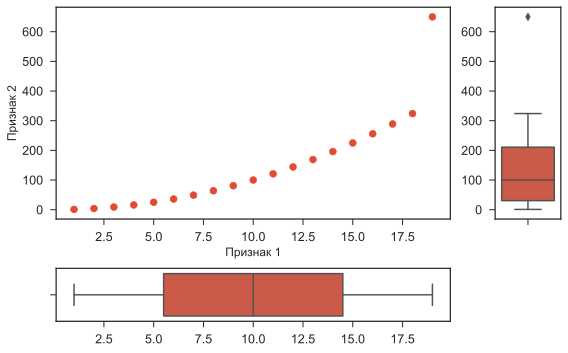

In [8]:
fig, ax = plt.subplots(2, 2, figsize=[8, 5], gridspec_kw={'width_ratios': [6, 1], 'height_ratios':[4, 1]})

ax[0, 0].scatter(x1, y1)
ax[0, 0].set_xlabel('Признак 1')
ax[0, 0].set_ylabel('Признак 2')
sns.boxplot(x=x1, ax=ax[1, 0])
sns.boxplot(y=y1, ax=ax[0, 1])

fig.delaxes(ax[1, 1])

plt.tight_layout()
plt.show()

А иногда понятно не все:

In [9]:
x2 = np.arange(1, 20)
y2 = x2 ** 2
y2[9] = y2[-2]

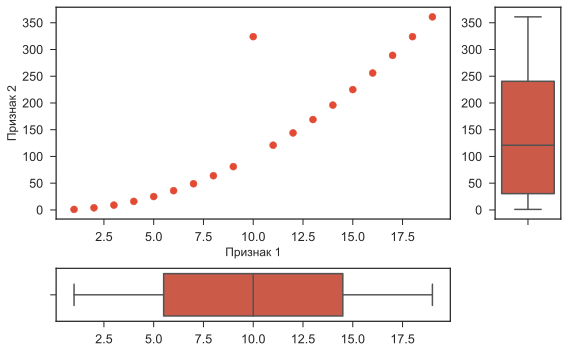

In [10]:
fig, ax = plt.subplots(2, 2, figsize=[8, 5], gridspec_kw={'width_ratios': [6, 1], 'height_ratios':[4, 1]})

ax[0, 0].scatter(x2, y2)
ax[0, 0].set_xlabel('Признак 1')
ax[0, 0].set_ylabel('Признак 2')
sns.boxplot(x=x2, ax=ax[1, 0])
sns.boxplot(y=y2, ax=ax[0, 1])

fig.delaxes(ax[1, 1])

plt.tight_layout()
plt.show()

Один из простейших методов детекции выбросов без обучения - правило Махаланобиса. Оно основано на расстоянии (внезапно) Махаланобиса, которое является обобщением Евклидова расстояния:

$D_M(x,y) ^2 = (x-y)^T * C^{-1} * (x - y)$, где x, y - векторы, между которыми определяется расстояние; $ C^{-1}$ - обратная ковариационная матрица.

Эта метрика устраняет корреляцию между осями и приводит измерения к единичной дисперсии.

Само правило основано на подсчете расстояния Махаланобиса от каждого наблюдения до центра выборки. Выбросами признаются наблюдение, расстояние от которых до центра превышает некоторый порог.

In [11]:
# создаем датафрейм из наших наблюдений
xy = pd.DataFrame({'x': x2, 'y': y2})
xy.head()

,x,y
0,1,1
1,2,4
2,3,9
3,4,16
4,5,25


In [12]:
# определяем центр наблюдений
center = xy.mean(axis=0)

In [13]:
# считаем обратную ковариационную матрицу
inv_cov_matrix = np.linalg.inv(np.cov(xy.T))

In [14]:
# считаем расстояние Махаланобиса от каждой точки до центра
xy['DM_to_center'] = xy.apply(lambda row: mahalanobis(row, center, inv_cov_matrix), axis=1)
xy.sort_values('DM_to_center', inplace=True)

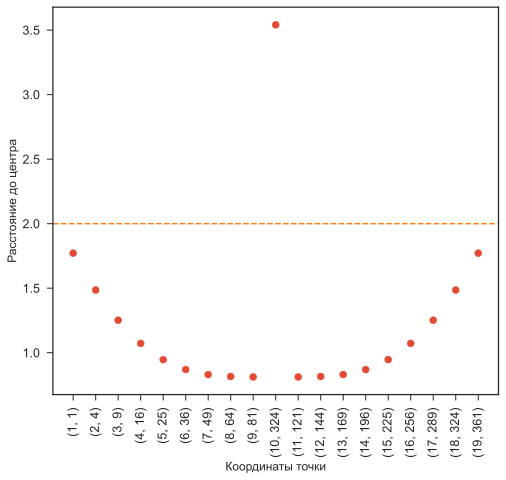

In [15]:
# визуализируем расстояния
plt.scatter(xy.index, xy['DM_to_center'])
plt.xticks(xy.index, '(' + xy['x'].astype('str') + ', ' + xy['y'].astype('str') + ')', rotation=90)
plt.xlabel('Координаты точки')
plt.ylabel('Расстояние до центра')
plt.axhline(2, linestyle='--', color='tab:orange')
plt.show()

In [16]:
xy['outlier'] = (xy['DM_to_center'] > 2).astype('int')
xy.sort_index(inplace=True)
xy

,x,y,DM_to_center,outlier
0,1,1,1.771593,0
1,2,4,1.485718,0
2,3,9,1.251800,0
3,4,16,1.072148,0
4,5,25,0.946537,0
5,6,36,0.869740,0
6,7,49,0.830818,0
7,8,64,0.815867,0
8,9,81,0.812362,0
9,10,324,3.541012,1


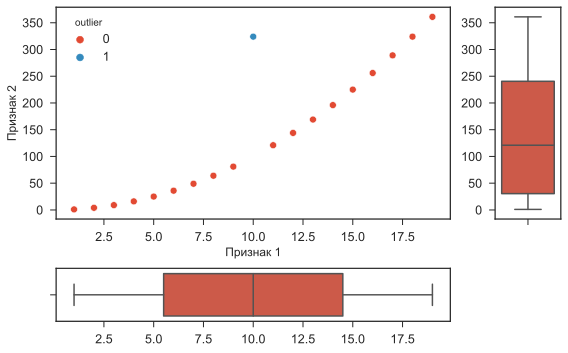

In [17]:
fig, ax = plt.subplots(2, 2, figsize=[8, 5], gridspec_kw={'width_ratios': [6, 1], 'height_ratios':[4, 1]})

sns.scatterplot(data=xy, x='x', y='y', hue='outlier', ax=ax[0, 0])
ax[0, 0].set_xlabel('Признак 1')
ax[0, 0].set_ylabel('Признак 2')
sns.boxplot(x=x2, ax=ax[1, 0])
sns.boxplot(y=y2, ax=ax[0, 1])

fig.delaxes(ax[1, 1])

plt.tight_layout()
plt.show()

# 3. Пропуски

## 3.1. Заполнение константой

In [18]:
df['education'].isna().sum() / len(df)

0.042026803923472855

Совсем простой способ:

In [19]:
df['education'].fillna('plebeians')

0                   basic.4y
1                high.school
2                high.school
3                   basic.6y
4                high.school
                ...         
41183    professional.course
41184    professional.course
41185      university.degree
41186    professional.course
41187    professional.course
Name: education, Length: 41188, dtype: object

Чуть менее простой способ:

In [20]:
imputer = SimpleImputer(strategy='constant', fill_value='plebeians')

In [21]:
imputer.fit(df[['education']])

SimpleImputer(fill_value='plebeians', strategy='constant')

In [22]:
df['education_imp'] = imputer.transform(df[['education']])

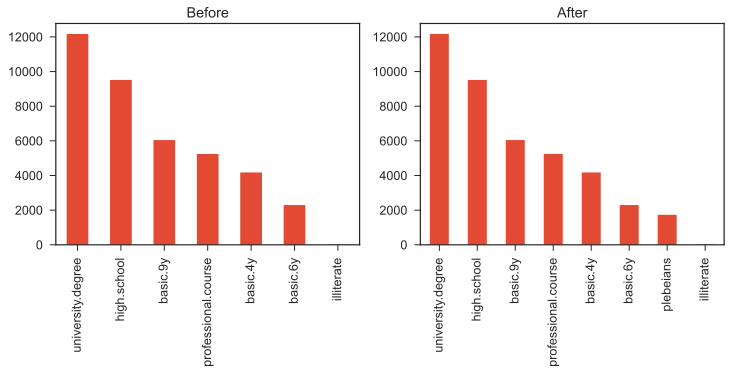

In [23]:
fig, ax = plt.subplots(1, 2, figsize=[12, 4])
df['education'].value_counts().plot.bar(ax=ax[0])
df['education_imp'].value_counts().plot.bar(ax=ax[1])
ax[0].set_title('Before')
ax[1].set_title('After')
plt.show()

In [24]:
imputer2 = SimpleImputer(strategy='most_frequent')

In [25]:
df['education_imp2'] = imputer2.fit_transform(df[['education']])

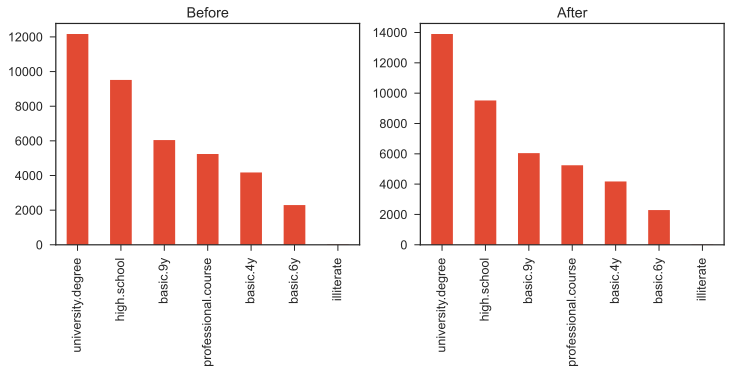

In [26]:
fig, ax = plt.subplots(1, 2, figsize=[12, 4])
df['education'].value_counts().plot.bar(ax=ax[0])
df['education_imp2'].value_counts().plot.bar(ax=ax[1])
ax[0].set_title('Before')
ax[1].set_title('After')
plt.show()

## 3.2. Заполнение поумнее

In [27]:
imputer3 = KNNImputer()

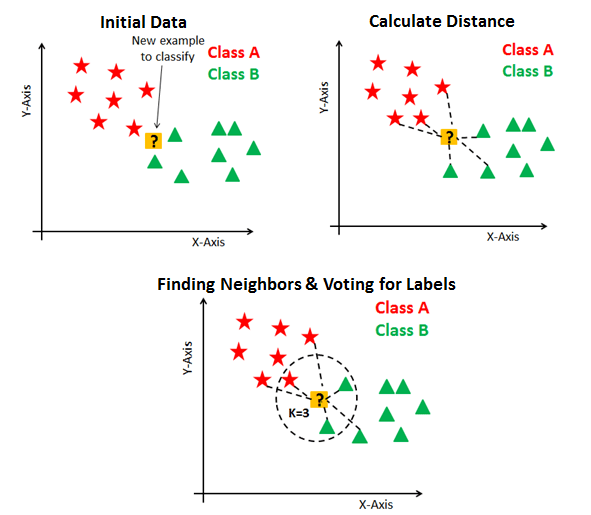

Нужны числовые признаки!

# 4. Нормализация (в широком смысле)

## 4.1. Нормализация (в узком смысле)

$ \Large x_{s} = \frac{x - x_{min}}{x_{max} - x_{min}} $

In [28]:
mm_scaler = MinMaxScaler()

In [29]:
age_mm = mm_scaler.fit_transform(df[['age']]).reshape(-1)

In [30]:
print('min = {:.2}'.format(min(age_mm)))
print('range = {:.2}'.format(max(age_mm) - min(age_mm)))

min = 0.0
range = 1.0


## 4.2. Стандартизация

$ \Large x_{s} = \frac{x - \mu}{\sigma} $

In [31]:
st_scaler = StandardScaler()

In [32]:
age_st = st_scaler.fit_transform(df[['age']]).reshape(-1)

In [33]:
print('mu = {:.2}'.format(np.mean(age_st)))
print('s = {:.2}'.format(np.std(age_st)))

mu = -1.9e-16
s = 1.0


## 4.3. Выбросоустойчивая (робастная) нормализация

$ \Large x_{s} = \frac{x - median}{IQR} $

In [34]:
rb_scaler = RobustScaler()

In [35]:
age_rb = rb_scaler.fit_transform(df[['age']]).reshape(-1)

In [36]:
print('med = {:.2}'.format(np.median(age_rb)))
print('IQR = {:.2}'.format(iqr(age_rb)))

med = 0.0
IQR = 1.0


## 4.4. Примеры

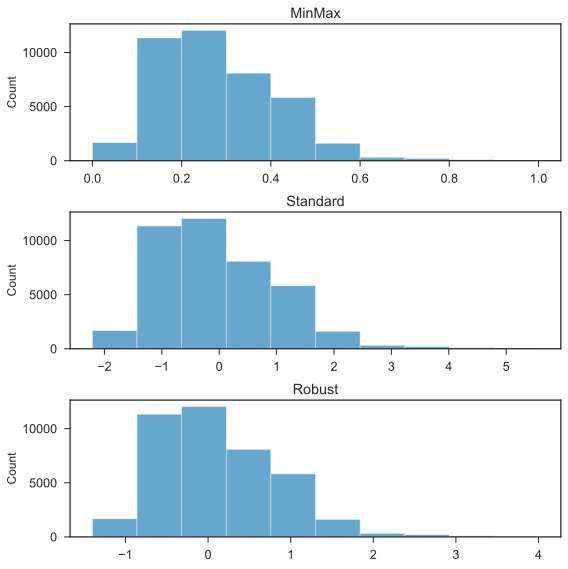

In [37]:
fig, ax = plt.subplots(3, 1, figsize=[8, 8])
sns.histplot(age_mm, bins=10, ax=ax[0])
sns.histplot(age_st, bins=10, ax=ax[1])
sns.histplot(age_rb, bins=10, ax=ax[2])
ax[0].set_title('MinMax')
ax[1].set_title('Standard')
ax[2].set_title('Robust')
plt.tight_layout()
plt.show()

# 5. Кодирование нечисловых признаков

## 5.1. Фиктивные переменные

In [38]:
oh_encoder = OneHotEncoder(sparse=False)

In [39]:
encoded = oh_encoder.fit_transform(df[['education']])
encoded

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [40]:
labels = oh_encoder.get_feature_names(['education'])
labels

array(['education_basic.4y', 'education_basic.6y', 'education_basic.9y',
       'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_nan'], dtype=object)

In [41]:
pd.DataFrame(encoded, columns=labels)

,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_nan
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
41183,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
41184,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
41185,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
41186,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## 5.2. Бинарное кодирование

In [42]:
bin_encoder = BinaryEncoder()

In [43]:
encoded = bin_encoder.fit_transform(df[['education']])
encoded

,education_0,education_1,education_2,education_3
0,0,0,0,1
1,0,0,1,0
2,0,0,1,0
3,0,0,1,1
4,0,0,1,0
...,...,...,...,...
41183,0,1,0,1
41184,0,1,0,1
41185,0,1,1,1
41186,0,1,0,1


In [44]:
base_encoder = BaseNEncoder(base=3)

In [45]:
encoded = base_encoder.fit_transform(df[['education']])
encoded

,education_0,education_1,education_2
0,0,0,1
1,0,0,2
2,0,0,2
3,0,1,0
4,0,0,2
...,...,...,...
41183,0,1,2
41184,0,1,2
41185,0,2,1
41186,0,1,2


## 5.3. Порядковое кодирование

In [46]:
education_sorted = {'illiterate': 0, 'unknown': 1, 'basic.4y': 2,
                    'basic.6y': 3, 'basic.9y': 4, 'high.school': 5,
                    'professional.course': 6, 'university.degree': 7}

Обратите внимание: это `OrdinalEncoder` из `category_encoders`, а не из `sklearn.preprocessing`.

In [47]:
ord_encoder = OrdinalEncoder(mapping=[{'col': 'education', 'mapping': education_sorted}])

In [48]:
encoded = ord_encoder.fit_transform(df[['education']])
encoded

,education
0,2.0
1,5.0
2,5.0
3,3.0
4,5.0
...,...
41183,6.0
41184,6.0
41185,7.0
41186,6.0


## 5.4. Целе-вероятностное кодирование

In [49]:
rules = pd.DataFrame(columns=['education', 'education_encoded'])

for cat in df['education_imp'].unique():
    cat_n = (df['education_imp'] == cat).sum()
    pos_cat_n = ((df['education_imp'] == cat) & (df['y'] == 'yes')).sum()
    rules = rules.append({'education': cat, 'education_encoded': pos_cat_n / cat_n}, ignore_index=True)
    
rules

,education,education_encoded
0,basic.4y,0.0
1,high.school,0.0
2,basic.6y,0.0
3,basic.9y,0.0
4,professional.course,0.0
5,plebeians,0.0
6,university.degree,0.0
7,illiterate,0.0


In [50]:
df.merge(rules, on='education', how='left')[['education_encoded']]

,education_encoded
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
41183,0.0
41184,0.0
41185,0.0
41186,0.0


Плюс: всего один признак. Проблема: почти наверняка будущая модель переобучится.

In [51]:
t_encoder = TargetEncoder()

In [52]:
t_encoder.fit(df[['education']], df['y']);

In [53]:
t_encoder.transform(df[['education']])

,education
0,0.102490
1,0.108355
2,0.108355
3,0.082024
4,0.108355
...,...
41183,0.113485
41184,0.113485
41185,0.137245
41186,0.113485


# 6. Трансформация

In [54]:
transf = FunctionTransformer(func=np.log, inverse_func=np.exp)

In [55]:
df['duration_log'] = transf.fit_transform(df[['duration']])

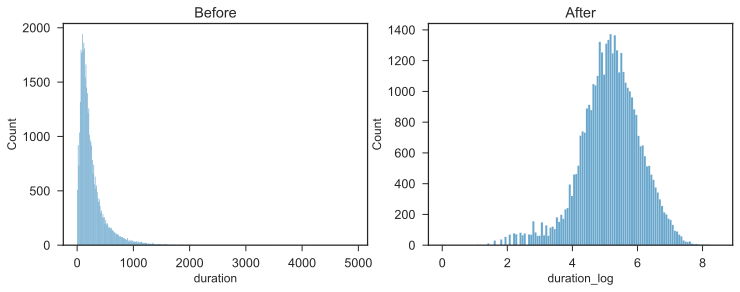

In [56]:
fig, ax = plt.subplots(1, 2, figsize=[12, 4])
sns.histplot(df['duration'], ax=ax[0])
sns.histplot(df['duration_log'], ax=ax[1])
ax[0].set_title('Before')
ax[1].set_title('After')
plt.show()

# 7. Композиция

[Полезная ссылка](https://scikit-learn.org/stable/modules/compose.html)

## 7.1. Pipeline

Позволяет делать несколько действий последовательно и выдавать результат последнего.

In [57]:
pipe_steps = [
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', TargetEncoder()),
    ('scaler', MinMaxScaler())
]

pipe = Pipeline(steps=pipe_steps)

In [58]:
pipe.fit(df[['job', 'marital', 'education']], df['y']);

In [59]:
pipe.transform(df[['job', 'marital', 'education']])

array([[0.12658562, 0.        , 0.16838905],
       [0.05069459, 0.        , 0.20912374],
       [0.05069459, 0.        , 0.20912374],
       ...,
       [0.7474546 , 0.        , 0.41649309],
       [0.16025454, 0.        , 0.2447507 ],
       [0.7474546 , 0.        , 0.2447507 ]])

## 7.2. FeatureUnion

Позволяет делать несколько действий параллельно и давать на выходе результат каждого.

In [60]:
trans_list = [
    ('log', FunctionTransformer(func=np.log, inverse_func=np.exp)),
    ('sqrt', FunctionTransformer(func=np.sqrt, inverse_func=lambda x: x ** 2))
]

In [61]:
union = FeatureUnion(transformer_list=trans_list)

In [62]:
union.fit(df[['duration', 'age']]);

In [63]:
union.transform(df[['age', 'duration']])

array([[ 4.02535169,  5.56452041,  7.48331477, 16.15549442],
       [ 4.04305127,  5.00394631,  7.54983444, 12.20655562],
       [ 3.61091791,  5.420535  ,  6.08276253, 15.03329638],
       ...,
       [ 4.02535169,  5.24174702,  7.48331477, 13.74772708],
       [ 3.78418963,  6.09130988,  6.63324958, 21.02379604],
       [ 4.30406509,  5.47646355,  8.60232527, 15.45962483]])

## 7.3. ColumnTransformer

Позволяет комбинировать различные преобразования для разных признаков.

In [64]:
transformer = ColumnTransformer(
    [('encode_and_scale', Pipeline(steps=pipe_steps), ['job', 'marital', 'education']),
     ('func_trans', FeatureUnion(transformer_list=trans_list), ['age', 'duration']),
    ('economics', StandardScaler(), ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'])]
)

In [67]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,education_imp,education_imp2,duration_log
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,basic.4y,basic.4y,5.564520
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,high.school,high.school,5.003946
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,high.school,high.school,5.420535
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,basic.6y,basic.6y,5.017280
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,high.school,high.school,5.726848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1,professional.course,professional.course,5.811141
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0,professional.course,professional.course,5.948035
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0,university.degree,university.degree,5.241747
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1,professional.course,professional.course,6.091310


In [65]:
transformer.fit(df, df['y'])

ColumnTransformer(transformers=[('encode_and_scale',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  TargetEncoder(cols=[0, 1,
                                                                      2])),
                                                 ('scaler', MinMaxScaler())]),
                                 ['job', 'marital', 'education']),
                                ('func_trans',
                                 FeatureUnion(transformer_list=[('log',
                                                                 FunctionTransformer(func=<ufunc 'log'>,
                                                                                     inverse_func=<ufunc 'exp'>)),
                                                                ('sqrt',
                       

In [66]:
transformer.transform(df)

array([[ 0.12658562,  0.        ,  0.16838905, ...,  0.88644656,
         0.71245988,  0.33167991],
       [ 0.05069459,  0.        ,  0.20912374, ...,  0.88644656,
         0.71245988,  0.33167991],
       [ 0.05069459,  0.        ,  0.20912374, ...,  0.88644656,
         0.71245988,  0.33167991],
       ...,
       [ 0.7474546 ,  0.        ,  0.41649309, ..., -2.22495344,
        -1.49518647, -2.8156966 ],
       [ 0.16025454,  0.        ,  0.2447507 , ..., -2.22495344,
        -1.49518647, -2.8156966 ],
       [ 0.7474546 ,  0.        ,  0.2447507 , ..., -2.22495344,
        -1.49518647, -2.8156966 ]])